In [3]:
import os
import glob
import re
import pandas as pd
import shutil
import zipfile
import geopandas as gpd
import requests
import json
import numpy as np
import _config

In [4]:
df_projects                     = _config.df_projects
tdm_transit_scenario            = _config.tdm_transit_scenario
input_model_line_files_folder   = _config.input_model_line_files_folder
input_tdm_link_shapefile_folder = _config.input_tdm_link_shapefile_folder
tdm_link_shapefile              = _config.tdm_link_shapefile
tdm_node_shapefile              = _config.tdm_node_shapefile
input_tdm_node_shapefile_folder = _config.input_tdm_node_shapefile_folder
df_centers                      = _config.df_centers
input_taz_shapefile_folder      = _config.input_taz_shapefile_folder
taz_shapefile                   = _config.taz_shapefile
df_center_override              = _config.df_center_override

In [5]:
# Get transit line link data for projects

_df_transit_lin_files = pd.read_csv(os.path.join(input_model_line_files_folder, 'files.csv'))
_df_transit_lin_files_lines = pd.read_csv(os.path.join(input_model_line_files_folder, 'lines.csv'))
_df_transit_lin_files_links = pd.read_csv(os.path.join(input_model_line_files_folder, 'links.csv'))

_df_transit_lin_files_lines = pd.merge(_df_transit_lin_files, _df_transit_lin_files_lines, on=['file_index'])
_df_transit_lin_files_lines_links = pd.merge(_df_transit_lin_files_lines, _df_transit_lin_files_links, on=['file_index','name'])

df_project_transit_links = pd.merge(_df_transit_lin_files_lines_links, df_projects, left_on=['model','name'], right_on=['tdm_model','tdm_line_name'])
df_project_transit_links = df_project_transit_links[df_project_transit_links['transit_scenario']==tdm_transit_scenario]
df_project_transit_links = df_project_transit_links[['project_id','link_id']]
df_project_transit_links

,project_id,link_id
428,2,25381_25430
429,2,25430_25534
430,2,25534_25640
431,2,25640_25685
432,2,25685_25669
...,...,...
3155,1,15184_15183
3156,1,15183_15182
3157,1,15182_15181
3158,1,15181_15180


In [6]:
_df_transit_lin_files_nodes = pd.read_csv(os.path.join(input_model_line_files_folder, 'nodes.csv'))
_df_transit_lin_files_lines_nodes = pd.merge(_df_transit_lin_files_lines, _df_transit_lin_files_nodes, on=['file_index','name'])

df_project_transit_nodes = pd.merge(_df_transit_lin_files_lines_nodes, df_projects, left_on=['model','name'], right_on=['tdm_model','tdm_line_name'])
df_project_transit_nodes = df_project_transit_nodes[df_project_transit_nodes['transit_scenario']==tdm_transit_scenario]
df_project_transit_nodes = df_project_transit_nodes[df_project_transit_nodes['is_stop']==True]
df_project_transit_nodes = df_project_transit_nodes[['project_id','node_id','is_stop']]

df_project_transit_nodes

,project_id,node_id,is_stop
214,2,25381,True
220,2,25602,True
223,2,25351,True
225,2,25215,True
227,2,25077,True
233,2,24858,True
238,2,24726,True
242,2,24568,True
246,2,24467,True
251,2,15086,True


In [7]:
# Read the shapefile
gdf_tdm_link = gpd.read_file(os.path.join(input_tdm_link_shapefile_folder, tdm_link_shapefile))

In [8]:
gdf_tdm_node = gpd.read_file(os.path.join(input_tdm_node_shapefile_folder, tdm_node_shapefile))

In [9]:
gdf_tdm_link.crs

<Projected CRS: EPSG:26912>
Name: NAD83 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 114°W and 108°W - onshore and offshore. Canada - Alberta; Northwest Territories; Nunavut; Saskatchewan. United States (USA) - Arizona; Colorado; Idaho; Montana; New Mexico; Utah; Wyoming.
- bounds: (-114.0, 31.33, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

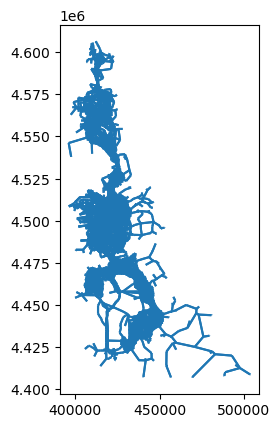

In [10]:
# display the gdf
gdf_tdm_link.plot()

<AxesSubplot:>

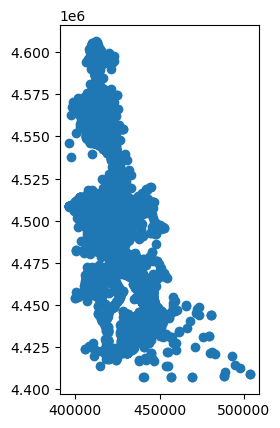

In [11]:
# display the gdf
gdf_tdm_node.plot()

In [12]:
# recalc link id because since it's not populated completely with changes.
gdf_tdm_link['LINKID'] = gdf_tdm_link['A'].astype(str) + '_' + gdf_tdm_link['B'].astype(str)

In [13]:
gdf_tdm_link = gdf_tdm_link[['A','B','LINKID','geometry']]
gdf_tdm_link

,A,B,LINKID,geometry
0,1,29685,1_29685,"LINESTRING (411935.000 4605642.000, 412478.126..."
1,2,29685,2_29685,"LINESTRING (412641.000 4606013.000, 412478.126..."
2,3,29645,3_29645,"LINESTRING (408993.000 4603544.000, 409632.415..."
3,4,29671,4_29671,"LINESTRING (410051.000 4604806.000, 409642.112..."
4,5,29680,5_29680,"LINESTRING (413394.000 4603600.000, 413482.000..."
...,...,...,...,...
57130,95064,95025,95064_95025,"LINESTRING (473181.550 4444171.200, 471782.100..."
57131,95064,95026,95064_95026,"LINESTRING (473181.550 4444171.200, 480751.220..."
57132,95064,95056,95064_95056,"LINESTRING (473181.550 4444171.200, 476015.900..."
57133,95065,3621,95065_3621,"LINESTRING (480730.710 4444037.000, 480767.876..."


In [14]:
df_project_transit_nodes

,project_id,node_id,is_stop
214,2,25381,True
220,2,25602,True
223,2,25351,True
225,2,25215,True
227,2,25077,True
233,2,24858,True
238,2,24726,True
242,2,24568,True
246,2,24467,True
251,2,15086,True


In [15]:
df_project_transit_nodes

,project_id,node_id,is_stop
214,2,25381,True
220,2,25602,True
223,2,25351,True
225,2,25215,True
227,2,25077,True
233,2,24858,True
238,2,24726,True
242,2,24568,True
246,2,24467,True
251,2,15086,True


,A,B,LINKID,geometry,project_id,link_id
0,10036,27491,10036_27491,"LINESTRING (414829.268 4549753.942, 414904.840...",3,10036_27491
1,10042,28166,10042_28166,"LINESTRING (412820.757 4560266.171, 412738.974...",3,10042_28166
2,10046,15180,10046_15180,"LINESTRING (417871.000 4564006.000, 417023.699...",1,10046_15180
3,15069,23429,15069_23429,"LINESTRING (419002.000 4505156.000, 419061.229...",2,15069_23429
4,15069,23429,15069_23429,"LINESTRING (419002.000 4505156.000, 419061.229...",2,15069_23429
...,...,...,...,...,...,...
319,28093,28117,28093_28117,"LINESTRING (411888.713 4560190.725, 412102.000...",3,28093_28117
320,28117,28093,28117_28093,"LINESTRING (412102.000 4560451.000, 411888.713...",3,28117_28093
321,28117,28166,28117_28166,"LINESTRING (412102.000 4560451.000, 412738.974...",3,28117_28166
322,28166,10042,28166_10042,"LINESTRING (412738.974 4560442.481, 412820.757...",3,28166_10042


,N,X,Y,GEOGKEY,EXTERNAL,HOTZN,TAZID,NODENAME,PNR_2015,PNR_2019,...,FARZN23_50,FARE23_32U,FARE23_42U,FARE23_50U,MAG_NODE,WFRC_NODE,geometry,project_id,node_id,is_stop
0,10036,414829.26830,4.549754e+06,414829_4549753,0,0,663,Clearfield,80,80,...,4,4,4,4,0,1,POINT (414829.268 4549753.942),3,10036,True
1,10042,412820.75670,4.560266e+06,412820_4560266,0,0,500,Roy,80,80,...,3,3,3,3,0,1,POINT (412820.757 4560266.171),3,10042,True
2,10046,417871.00000,4.564006e+06,417871_4564006,0,0,368,Ogden,80,80,...,2,2,2,2,0,1,POINT (417871.000 4564006.000),1,10046,True
3,15069,419002.00000,4.505156e+06,419002_4505156,0,0,1383,West Valley Central,70,70,...,0,0,0,0,0,1,POINT (419002.000 4505156.000),2,15069,True
4,15086,424229.00000,4.505924e+06,424229_4505924,0,0,1473,Millcreek,70,70,...,0,0,0,0,0,1,POINT (424229.000 4505924.000),2,15086,True
5,15180,417023.69862,4.565620e+06,NaN,0,0,0,NaN,0,0,...,0,0,0,0,0,0,POINT (417023.699 4565619.924),1,15180,True
6,15182,414033.26423,4.566399e+06,NaN,0,0,0,NaN,0,0,...,0,0,0,0,0,0,POINT (414033.264 4566398.825),1,15182,True
7,15183,412688.63081,4.566366e+06,NaN,0,0,0,NaN,0,0,...,0,0,0,0,0,0,POINT (412688.631 4566365.991),1,15183,True
8,15184,411527.01167,4.566354e+06,NaN,0,0,0,NaN,0,0,...,0,0,0,0,0,0,POINT (411527.012 4566354.138),1,15184,True
9,15185,410039.42797,4.566378e+06,NaN,0,0,0,NaN,0,0,...,0,0,0,0,0,0,POINT (410039.428 4566377.845),1,15185,True


<AxesSubplot:>

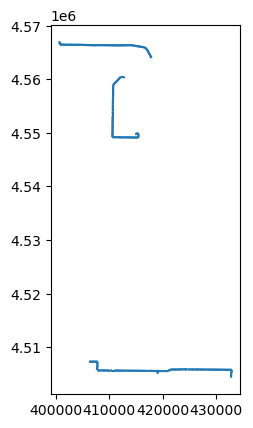

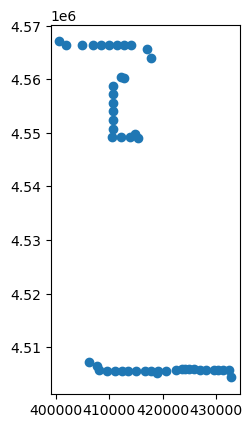

In [16]:
gdf_tdm_link_with_projects = pd.merge(gdf_tdm_link, df_project_transit_links, left_on='LINKID', right_on='link_id')
display(gdf_tdm_link_with_projects)
gdf_tdm_link_with_projects.plot()

gdf_tdm_node_with_projects = pd.merge(gdf_tdm_node, df_project_transit_nodes, left_on='N', right_on='node_id')
display(gdf_tdm_node_with_projects)
gdf_tdm_node_with_projects.plot()

In [17]:
df_centers

,center_type,FAR,bldg_size,size_of_hh_units,sf_per_employee,units_per_acre,sf_per_acre,%_residential,%_non_res,"gross_to_net_conversion_(streets,_etc)",final_units_per_acre,final_emps_per_acre,application_area,application_area_miles,household_size,office_retail_split
0,Neighborhood Center,0.6,26136,1000,500,26.136,52.27,0.85,0.15,0.8,18,6,1/8 mile radius,0.125,1.62,20/80
1,City Center,1.13,49222.8,850,450,57.909176,109.38,0.85,0.15,0.8,39,13,990 foot radius,0.1875,1.62,30/70
2,Urban Center,1.5,65340,750,400,87.12,163.35,0.85,0.15,0.8,59,20,1/4 mile radius,0.25,1.62,40/60
3,Metropolitan Center,2.0,86734,650,350,133.43,247.81,0.85,0.15,0.8,91,30,1/3 mile radius,0.3333,1.62,50/50


In [18]:
#gdf_buffered_projects_by_center_type = gpd.GeoDataFrame()
#
#for index, row in df_centers.iterrows():
#    print(row['center type'])
#
#    # Merging lines based on 'project_id'
#    _gdf_tdm_link_with_projects_merged = gdf_tdm_link_with_projects.dissolve(by='project_id')
#    _gdf_tdm_link_with_projects_merged['center type'] = row['center type']
#
#    # Buffer the merged lines by 'application area miles'
#    # Convert miles to an appropriate unit if your CRS is not in miles
#    # For example, if CRS is in meters, convert miles to meters (1 mile = 1609.34 meters)
#    _gdf_tdm_link_with_projects_merged['buffered'] = _gdf_tdm_link_with_projects_merged.geometry.buffer(row['application area miles'] * 1609.34)
#
#    # If you want the buffered geometry as the main geometry
#    _gdf_tdm_link_with_projects_merged.set_geometry('buffered', inplace=True)
#
#    _gdf_tdm_link_with_projects_merged.drop(columns=['geometry','A','B','LINKID','link_id'], inplace=True)
#    _gdf_tdm_link_with_projects_merged.reset_index(inplace=True)
#
#    _gdf_tdm_link_with_projects_merged.plot()
#
#    gdf_buffered_projects_by_center_type = pd.concat([gdf_buffered_projects_by_center_type,_gdf_tdm_link_with_projects_merged])
#
#display(gdf_buffered_projects_by_center_type)

,OBJECTID,AreaName,AreaType,Area,Shape__Area,Shape__Length,geometry
3,28,Canyons,Neighborhood Center,Summit County,4.571034e+05,2580.425872,"POLYGON ((452906.669 4504138.938, 453337.539 4..."
4,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,"POLYGON ((421588.154 4469656.985, 421588.155 4..."
5,39,Deer Valley Base,Neighborhood Center,Summit County,1.626199e+05,2318.218626,"POLYGON ((459498.130 4499177.318, 459512.730 4..."
7,43,Downtown Provo,Urban Center,Utah County,1.267076e+07,30147.565078,"POLYGON ((444202.107 4456362.513, 444206.567 4..."
8,46,Downtown Springville,City Center,Utah County,2.891819e+06,13102.452873,"POLYGON ((445119.776 4446055.292, 447868.307 4..."
...,...,...,...,...,...,...,...
296,511,Cottonwood Village,Neighborhood Center,WFRC MPO,1.275807e+05,1603.672031,"POLYGON ((428976.795 4502431.078, 428978.502 4..."
297,512,Independence,City Center,WFRC MPO,5.686543e+06,11136.244285,"POLYGON ((420920.227 4479707.977, 420935.444 4..."
298,513,Porter Rockwell,Urban Center,WFRC MPO,4.110667e+06,10191.341842,"POLYGON ((423145.110 4480905.812, 423142.073 4..."
299,514,Washington Terrace US 89,City Center,WFRC MPO,1.478004e+06,7268.026224,"POLYGON ((418306.763 4557002.282, 418306.874 4..."


<AxesSubplot:>

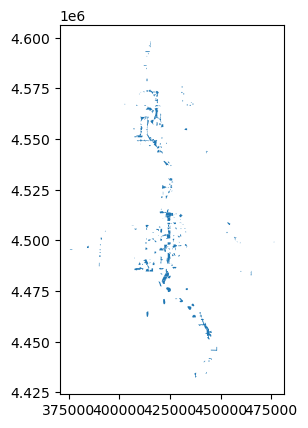

In [19]:
# read in wasatch choice center dataset and convert to UTM Zone 12N
gdf_wc_centers = gpd.read_file('input/wasatch-choice-centers/wc-centers.geojson')
gdf_wc_centers = gdf_wc_centers.to_crs(26912)

# filter for area types 
# Get the unique center types from df_centers
center_types = df_centers['center_type'].unique()

# Filter gdf_wc_centers based on the center types
gdf_filtered_centers = gdf_wc_centers[gdf_wc_centers['AreaType'].isin(center_types)]

display(gdf_filtered_centers)
display(gdf_filtered_centers.plot())

In [20]:
gdf_wc_centers.groupby(['AreaType']).count()

,OBJECTID,AreaName,Area,Shape__Area,Shape__Length,geometry
AreaType,,,,,,
City Center,90,90,90,90,90,90
Educational Center,10,10,10,10,10,10
Employment District,28,28,28,28,28,28
Industrial District,28,28,28,28,28,28
Metropolitan Center,2,2,2,2,2,2
Neighborhood Center,112,112,112,112,112,112
Special District,10,10,10,10,10,10
Urban Center,22,22,22,22,22,22


In [21]:
import geopandas as gpd
import pandas as pd
from shapely.ops import nearest_points

conversion_factor = 0.000621371


# Function to find the nearest polygon
def find_nearest_polygon(point_gdf, polygon_gdf):
    temp_df_list = []
    
    for point_idx, point in point_gdf.iterrows():
        polygon_gdf['distance'] = polygon_gdf.geometry.apply(lambda geom: point.geometry.distance(geom))
        nearest_polygon_idx = polygon_gdf['distance'].idxmin()
        distance_in_miles = polygon_gdf.loc[nearest_polygon_idx, 'distance'] * conversion_factor

        temp_df_list.append({
            'point_index': point_idx,
            'polygon_index': nearest_polygon_idx,
            'distance_in_miles': distance_in_miles
        })
    
    return pd.concat([pd.DataFrame([d]) for d in temp_df_list], ignore_index=True)

# Apply the function to find nearest polygons
nearest_polygons_df = find_nearest_polygon(gdf_tdm_node_with_projects, gdf_filtered_centers)

# Join the nearest polygon info back to the original points GeoDataFrame
gdf_nearest_polygons = gdf_tdm_node_with_projects.join(
    nearest_polygons_df.set_index('point_index')['polygon_index'], how='left'
).merge(
    gdf_filtered_centers.rename(columns=lambda x: f'nearest_{x}'),
    left_on='polygon_index', right_index=True, how='left'
).join(
    nearest_polygons_df.set_index('point_index')['distance_in_miles'], how='left'
)

# Inspect the result
#display(gdf_nearest_polygons)

df_nearest_centers = gdf_nearest_polygons.copy()
df_nearest_centers = df_nearest_centers[['project_id','N','nearest_AreaType','distance_in_miles']]

df_nearest_centers['nearest_AreaType_original'] = df_nearest_centers['nearest_AreaType']
# Update 'nearest_AreaType' and 'distance_in_miles' based on the condition
df_nearest_centers.loc[df_nearest_centers['distance_in_miles'] > 1, 'nearest_AreaType'] = 'Neighborhood Center'
df_nearest_centers.loc[df_nearest_centers['distance_in_miles'] > 1, 'distance_in_miles'] = 99999

display(df_nearest_centers)

C:\Users\bhereth\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\bhereth\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\bhereth\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,project_id,N,nearest_AreaType,distance_in_miles,nearest_AreaType_original
0,3,10036,Urban Center,0.005376,Urban Center
1,3,10042,City Center,0.000000,City Center
2,1,10046,Metropolitan Center,0.000000,Metropolitan Center
3,2,15069,Urban Center,0.000000,Urban Center
4,2,15086,Neighborhood Center,0.000000,Neighborhood Center
5,1,15180,Metropolitan Center,0.442349,Metropolitan Center
6,1,15182,City Center,0.281945,City Center
7,1,15183,Neighborhood Center,0.046341,Neighborhood Center
8,1,15184,Neighborhood Center,0.476013,Neighborhood Center
9,1,15185,Neighborhood Center,0.502924,Neighborhood Center


In [31]:
# override

# Merge dataframes to get the override values
merged_df = df_nearest_centers.merge(df_center_override, on='N', how='left', suffixes=('', '_override'))

# Update the nearest_AreaType with the override values where available
df_nearest_centers['nearest_AreaType'] = merged_df['nearest_AreaType_override'].combine_first(merged_df['nearest_AreaType'])

display(df_nearest_centers)


,project_id,N,nearest_AreaType,distance_in_miles,nearest_AreaType_original
0,3,10036,Urban Center,0.005376,Urban Center
1,3,10042,City Center,0.000000,City Center
2,1,10046,Metropolitan Center,0.000000,Metropolitan Center
3,2,15069,Urban Center,0.000000,Urban Center
4,2,15086,Neighborhood Center,0.000000,Neighborhood Center
5,1,15180,Urban Center,0.442349,Metropolitan Center
6,1,15182,City Center,0.281945,City Center
7,1,15183,Neighborhood Center,0.046341,Neighborhood Center
8,1,15184,Neighborhood Center,0.476013,Neighborhood Center
9,1,15185,Neighborhood Center,0.502924,Neighborhood Center


In [32]:
gdf_stops = gdf_tdm_node_with_projects[['N','geometry']]
gdf_stops_with_nearest_center = pd.merge(gdf_stops, df_nearest_centers[['project_id','N','nearest_AreaType']], on='N')
gdf_stops_with_nearest_center

,N,geometry,project_id,nearest_AreaType
0,10036,POINT (414829.268 4549753.942),3,Urban Center
1,10042,POINT (412820.757 4560266.171),3,City Center
2,10046,POINT (417871.000 4564006.000),1,Metropolitan Center
3,15069,POINT (419002.000 4505156.000),2,Urban Center
4,15086,POINT (424229.000 4505924.000),2,Neighborhood Center
5,15180,POINT (417023.699 4565619.924),1,Urban Center
6,15182,POINT (414033.264 4566398.825),1,City Center
7,15183,POINT (412688.631 4566365.991),1,Neighborhood Center
8,15184,POINT (411527.012 4566354.138),1,Neighborhood Center
9,15185,POINT (410039.428 4566377.845),1,Neighborhood Center


Neighborhood Center
City Center
Urban Center


C:\Users\bhereth\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\bhereth\AppData\Local\Temp\ipykernel_4188\2291757004.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _gdf.drop(columns=['geometry'], inplace=True)
C:\Users\bhereth\AppData\Local\Temp\ipykernel_4188\2291757004.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

Metropolitan Center


C:\Users\bhereth\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\bhereth\AppData\Local\Temp\ipykernel_4188\2291757004.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _gdf.drop(columns=['geometry'], inplace=True)
C:\Users\bhereth\AppData\Local\Temp\ipykernel_4188\2291757004.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,index,N,project_id,nearest_AreaType,geometry
0,4,15086,2,Neighborhood Center,"POLYGON ((424430.167 4505924.000, 424429.199 4..."
1,7,15183,1,Neighborhood Center,"POLYGON ((412889.798 4566365.991, 412888.830 4..."
2,8,15184,1,Neighborhood Center,"POLYGON ((411728.179 4566354.138, 411727.210 4..."
3,9,15185,1,Neighborhood Center,"POLYGON ((410240.595 4566377.845, 410239.627 4..."
4,10,15186,1,Neighborhood Center,"POLYGON ((408741.159 4566401.551, 408740.190 4..."
5,11,15187,1,Neighborhood Center,"POLYGON ((407170.602 4566383.771, 407169.633 4..."
6,12,15188,1,Neighborhood Center,"POLYGON ((405019.236 4566454.891, 405018.267 4..."
7,13,15189,1,Neighborhood Center,"POLYGON ((402162.601 4566472.671, 402161.632 4..."
8,14,15191,1,Neighborhood Center,"POLYGON ((400864.670 4567083.113, 400863.701 4..."
9,15,21884,2,Neighborhood Center,"POLYGON ((406400.687 4507262.802, 406399.719 4..."


<AxesSubplot:>

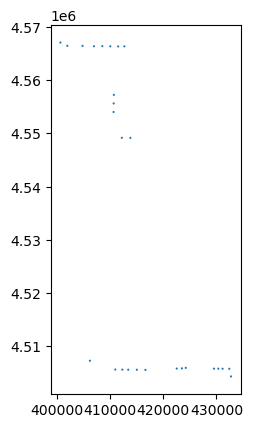

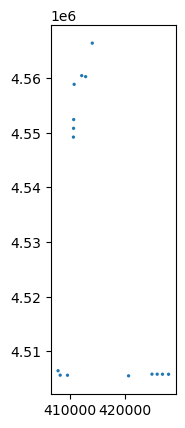

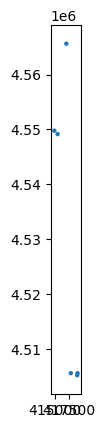

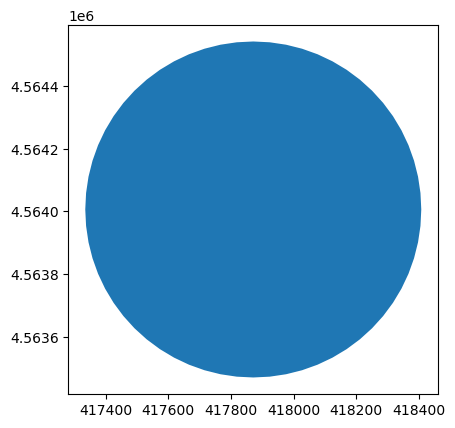

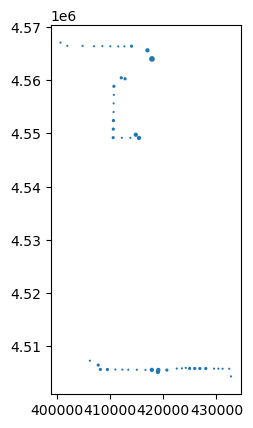

In [33]:
_gdfs = []

gdf_buffered_stops_with_centers = gpd.GeoDataFrame()

for index, row in df_centers.iterrows():
    print(row['center_type'])

    _gdf = gdf_stops_with_nearest_center[gdf_stops_with_nearest_center['nearest_AreaType']==row['center_type']]

    # Buffer the merged lines by 'application area miles'
    # Convert miles to an appropriate unit if your CRS is not in miles
    # For example, if CRS is in meters, convert miles to meters (1 mile = 1609.34 meters)
    _gdf['buffered'] = _gdf.geometry.buffer(row['application_area_miles'] * 1609.34)

    # If you want the buffered geometry as the main geometry
    _gdf.set_geometry('buffered', inplace=True)

    _gdf.drop(columns=['geometry'], inplace=True)
    _gdf.reset_index(inplace=True)

    _gdf.rename(columns={'buffered':'geometry'}, inplace=True)

    # If you want the buffered geometry as the main geometry
    _gdf.set_geometry('geometry', inplace=True)
    
    _gdf.plot()

    gdf_buffered_stops_with_centers = pd.concat([gdf_buffered_stops_with_centers,_gdf])

    _gdfs.append(_gdf)

display(gdf_buffered_stops_with_centers)

gdf_buffered_stops_with_centers.plot()

'IMPORTANT... MAY ONLY WORK WITH MAX OF 2 OVERLAPPING POLYGONS PER OVERLAP SET!'

C:\Users\bhereth\AppData\Local\Temp\ipykernel_4188\1860124914.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf_overlapping_polygons = gdf_overlapping_polygons.append(poly1)
C:\Users\bhereth\AppData\Local\Temp\ipykernel_4188\1860124914.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf_overlapping_polygons = gdf_overlapping_polygons.append(poly2)


,index,N,project_id,nearest_AreaType,geometry,intersect_set_id
0,3,15069,2,Urban Center,"POLYGON ((419404.335 4505156.000, 419402.398 4...",0.0
1,25,23506,2,Urban Center,"POLYGON ((419465.703 4505526.201, 419463.766 4...",0.0


<AxesSubplot:>

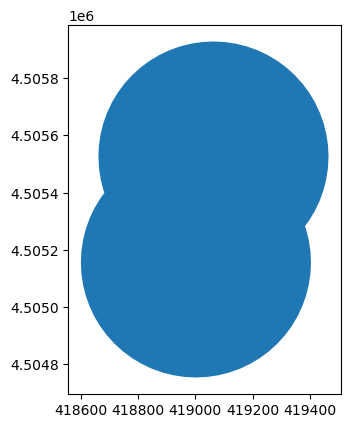

In [34]:
# figure out sets of overlapping polygons

import geopandas as gpd
from shapely.geometry import Polygon

gdf = gdf_buffered_stops_with_centers

# Assuming you already have your GeoDataFrame 'gdf'
# Create an empty GeoDataFrame with the same CRS as the original
gdf_overlapping_polygons = gpd.GeoDataFrame(columns=gdf.columns, crs=gdf.crs)

intersect_set_id = 0;

display("IMPORTANT... MAY ONLY WORK WITH MAX OF 2 OVERLAPPING POLYGONS PER OVERLAP SET!")

# Check each polygon against every other polygon
for i, poly1 in gdf.iterrows():
    for j, poly2 in gdf.iterrows():
        if i >= j:
            continue
        if poly1.geometry.intersects(poly2.geometry):
            poly2['intersect_set_id'] = intersect_set_id
            poly1['intersect_set_id'] = intersect_set_id
            gdf_overlapping_polygons = gdf_overlapping_polygons.append(poly1)
            gdf_overlapping_polygons = gdf_overlapping_polygons.append(poly2)
            intersect_set_id += 1

# Remove duplicates
gdf_overlapping_polygons = gdf_overlapping_polygons.drop_duplicates()

# Reset index
gdf_overlapping_polygons = gdf_overlapping_polygons.reset_index(drop=True)

# Display or save the resulting GeoDataFrame
display(gdf_overlapping_polygons)
display(gdf_overlapping_polygons.plot())

In [35]:
df_centers_rank = df_centers[['center_type','final_units_per_acre','final_emps_per_acre']].copy()
df_centers_rank['rank_per_acre'] = df_centers_rank['final_units_per_acre'] + df_centers_rank['final_emps_per_acre']
df_centers_rank = df_centers_rank[['center_type','rank_per_acre']]
df_centers_rank

,center_type,rank_per_acre
0,Neighborhood Center,24
1,City Center,52
2,Urban Center,79
3,Metropolitan Center,121


,index,N,project_id,nearest_AreaType,geometry,intersect_set_id
0,3,15069,2,Urban Center,"POLYGON ((419404.335 4505156.000, 419402.398 4...",0.0
1,25,23506,2,Urban Center,"POLYGON ((419465.703 4505526.201, 419463.766 4...",0.0


,index,N,project_id,nearest_AreaType,geometry
0,3,15069,2,Urban Center,"POLYGON ((419404.335 4505156.000, 419402.398 4..."


,index,N,project_id,nearest_AreaType,geometry
1,25,23506,2,Urban Center,"POLYGON ((419465.703 4505526.201, 419463.766 4..."


'Intersected polygon with attributes of highest ranked:'

,geometry,N,project_id,nearest_AreaType,intersect_set_id
0,"POLYGON ((418690.991 4505411.239, 418717.506 4...",15069,2,Urban Center,0.0


'Difference polygon 1:'

,geometry,N,project_id,nearest_AreaType,intersect_set_id
0,"POLYGON ((419402.398 4505116.564, 419396.604 4...",15069,2,Urban Center,0.0


'Difference polygon 2:'

,geometry,N,project_id,nearest_AreaType,intersect_set_id
0,"POLYGON ((419463.766 4505486.765, 419457.973 4...",23506,2,Urban Center,0.0


,N,project_id,nearest_AreaType,geometry,intersect_set_id
0,15069,2,Urban Center,"POLYGON ((419396.604 4505077.508, 419387.011 4...",0.0
1,23506,2,Urban Center,"POLYGON ((419463.766 4505486.765, 419457.973 4...",0.0


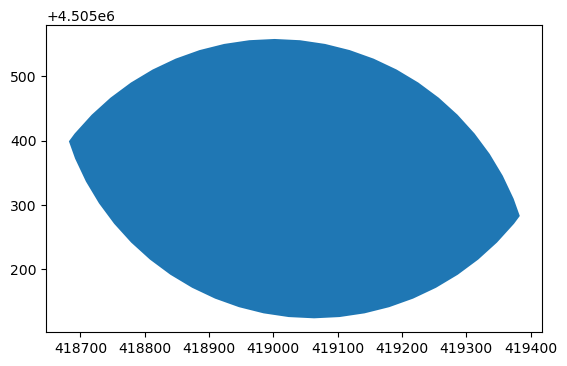

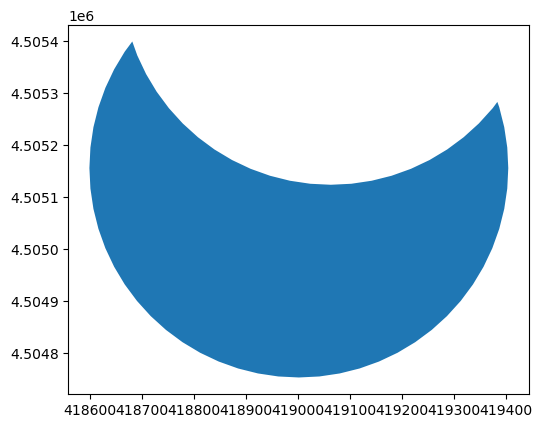

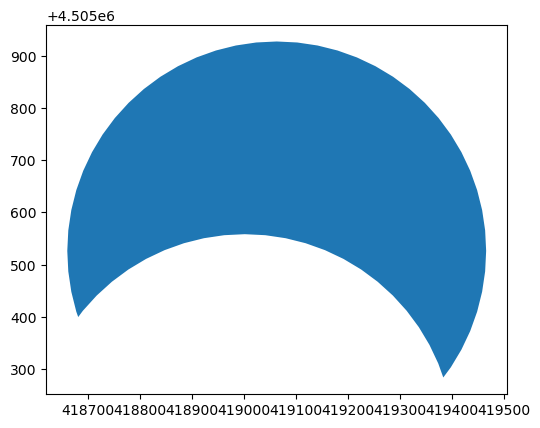

In [36]:
# for each interesect_set_id 

_gdf = gdf_overlapping_polygons

# Loop through unique values of 'intersect_set_id' and filter the DataFrame
unique_intersect_set_ids = _gdf['intersect_set_id'].unique()

gdf_overlap_pieces = pd.DataFrame()

filtered_dfs = {}

for intersect_set_id in unique_intersect_set_ids:
    filtered_df = _gdf[_gdf['intersect_set_id'] == intersect_set_id]
    filtered_dfs[intersect_set_id] = filtered_df
    display(filtered_df)

    # get data for highest ranking
    filtered_df_centers_rank = pd.merge(filtered_df, df_centers_rank, left_on='nearest_AreaType', right_on='center_type')

    # Sort the DataFrame by the desired columns
    sorted_df = filtered_df_centers_rank.sort_values(
        by=['rank_per_acre', 'project_id', 'N'],
        ascending=[False, True, True]
    )

    # Get the top record after sorting
    top_record = sorted_df.iloc[0]
    # Create a new DataFrame with the selected columns
    top_record_df = top_record[['N', 'project_id', 'nearest_AreaType']].to_frame().transpose()

    #display(top_record_df)

    # create gdf for each polygon
    # Create an array of GeoDataFrames, each containing a single polygon
    gdf_array = []

    for index, row in filtered_df.iterrows():
        single_polygon_gdf = gpd.GeoDataFrame([row], columns=gdf.columns)
        gdf_array.append(single_polygon_gdf)
        display(single_polygon_gdf)

    # find intersect (1 polygon), take max values

    # Start with the first GeoDataFrame's geometry
    intersection_polygon = gdf_array[0].geometry.iloc[0]

    # Find the intersection
    intersection_polygon = intersection_polygon.intersection(gdf_array[1].geometry.iloc[0])

    intersection_gdf = gpd.GeoDataFrame(geometry=[intersection_polygon])
    intersection_gdf = pd.merge(intersection_gdf, top_record_df, how='cross')
    intersection_gdf['intersect_set_id'] = intersect_set_id
    intersection_gdf.plot()
    display('Intersected polygon with attributes of highest ranked:')
    display(intersection_gdf)

    # find difference (2 polygons)

    difference_polygon_1 = gdf_array[0].geometry.iloc[0]
    difference_polygon_2 = gdf_array[1].geometry.iloc[0]
    difference_polygon_1 = difference_polygon_1.difference(gdf_array[1].geometry.iloc[0])
    difference_polygon_2 = difference_polygon_2.difference(gdf_array[0].geometry.iloc[0])

    difference_1_gdf = gpd.GeoDataFrame(geometry=[difference_polygon_1])
    difference_1_gdf = pd.merge(difference_1_gdf, gdf_array[0][['N','project_id','nearest_AreaType']], how='cross')
    difference_1_gdf['intersect_set_id'] = intersect_set_id
    difference_1_gdf.plot()
    display('Difference polygon 1:')
    display(difference_1_gdf)

    difference_2_gdf = gpd.GeoDataFrame(geometry=[difference_polygon_2])
    difference_2_gdf = pd.merge(difference_2_gdf, gdf_array[1][['N','project_id','nearest_AreaType']], how='cross')
    difference_2_gdf['intersect_set_id'] = intersect_set_id
    difference_2_gdf.plot()
    display('Difference polygon 2:')
    display(difference_2_gdf)

    # concat intersect and difference
    # concat intersect_set_id
    gdf_overlap_pieces = pd.concat([gdf_overlap_pieces, intersection_gdf, difference_1_gdf, difference_2_gdf])

# Assuming gdf_overlap_pieces is your GeoDataFrame
gdf_overlap_pieces_dissolved = gdf_overlap_pieces.dissolve(by=['N', 'project_id', 'nearest_AreaType'])
gdf_overlap_pieces_dissolved.reset_index(inplace=True)

display(gdf_overlap_pieces_dissolved)


<AxesSubplot:>

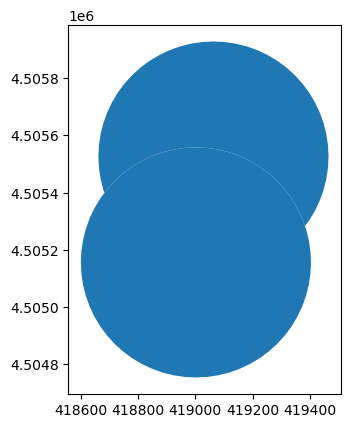

In [37]:
gdf_overlap_pieces_dissolved.plot()

<AxesSubplot:>

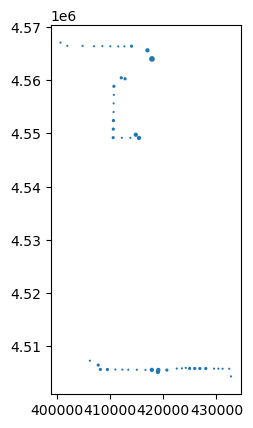

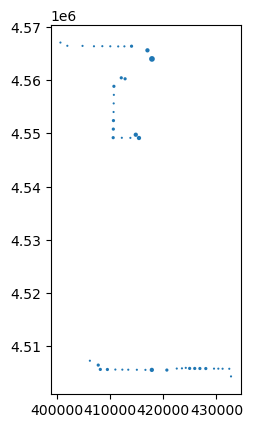

In [38]:
# remove overlapping from original dataset so they can be replaced 

gdf_buffered_stops_with_centers_copy = gdf_buffered_stops_with_centers.copy()

for overlapping_polygon in gdf_overlapping_polygons.geometry:
    gdf_buffered_stops_with_centers_copy['geometry'] = gdf_buffered_stops_with_centers_copy.geometry.apply(lambda x: x.difference(overlapping_polygon))
    
# Remove any empty geometries that may result from the difference operation
gdf_buffered_stops_with_centers_copy_no_overlapping = gdf_buffered_stops_with_centers_copy[~gdf_buffered_stops_with_centers_copy.is_empty]

# Display the result
gdf_buffered_stops_with_centers.plot()
gdf_buffered_stops_with_centers_copy_no_overlapping.plot()

C:\Users\bhereth\AppData\Roaming\Python\Python39\site-packages\geopandas\array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83 / UTM zone 12N (the single non-null crs provided).
  warnings.warn(


,N,project_id,nearest_AreaType,geometry
0,15086,2,Neighborhood Center,"POLYGON ((424426.302 4505884.754, 424421.505 4..."
1,15183,1,Neighborhood Center,"POLYGON ((412885.933 4566326.745, 412881.136 4..."
2,15184,1,Neighborhood Center,"POLYGON ((411724.314 4566314.892, 411719.517 4..."
3,15185,1,Neighborhood Center,"POLYGON ((410236.730 4566338.599, 410231.933 4..."
4,15186,1,Neighborhood Center,"POLYGON ((408737.293 4566362.305, 408732.496 4..."
5,15187,1,Neighborhood Center,"POLYGON ((407166.737 4566344.525, 407161.940 4..."
6,15188,1,Neighborhood Center,"POLYGON ((405015.371 4566415.645, 405010.574 4..."
7,15189,1,Neighborhood Center,"POLYGON ((402158.736 4566433.425, 402153.939 4..."
8,15191,1,Neighborhood Center,"POLYGON ((400860.804 4567043.867, 400856.007 4..."
9,21884,2,Neighborhood Center,"POLYGON ((406396.822 4507223.556, 406392.025 4..."


<AxesSubplot:>

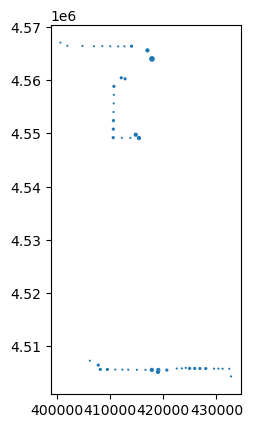

In [39]:
gdf_buffered_stops_with_centers_final = pd.concat([gdf_buffered_stops_with_centers_copy_no_overlapping, gdf_overlap_pieces_dissolved], ignore_index=True)
gdf_buffered_stops_with_centers_final = gdf_buffered_stops_with_centers_final[['N','project_id','nearest_AreaType','geometry']]
display(gdf_buffered_stops_with_centers_final)
gdf_buffered_stops_with_centers_final.plot()

<AxesSubplot:>

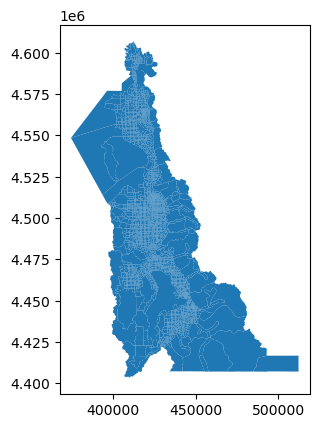

In [40]:
# import taz shapefile
gdf_taz = gpd.read_file(os.path.join(input_taz_shapefile_folder, taz_shapefile))
gdf_taz.rename(columns={'ACRES':'TAZACRES'}, inplace=True)
gdf_taz = gdf_taz.to_crs(26912)
gdf_taz.plot()

,N,project_id,nearest_AreaType,TAZID,TAZACRES,geometry,sqm,acres
0,15086,2,Neighborhood Center,1472,42.036264,"POLYGON ((424043.145 4505847.017, 424036.495 4...",49740.404222,12.291122
1,15086,2,Neighborhood Center,1473,44.089344,"POLYGON ((424421.505 4505865.604, 424414.855 4...",52165.559080,12.890390
2,15086,2,Neighborhood Center,1481,68.022708,"POLYGON ((424229.000 4505722.832, 424209.282 4...",13056.790069,3.226403
3,15086,2,Neighborhood Center,1482,39.922698,"POLYGON ((424396.265 4505812.237, 424384.505 4...",11968.229688,2.957414
4,15183,1,Neighborhood Center,176,288.616036,"POLYGON ((412496.126 4566424.387, 412502.776 4...",35706.046305,8.823156
...,...,...,...,...,...,...,...,...
173,15069,2,Urban Center,1383,82.068433,"POLYGON ((418599.665 4505156.000, 418601.602 4...",163541.758588,40.412049
174,23506,2,Urban Center,1383,82.068433,"POLYGON ((418812.341 4505510.828, 418778.475 4...",10615.218005,2.623077
175,15069,2,Urban Center,1384,96.889876,"POLYGON ((419387.011 4505039.208, 419373.709 4...",208196.248028,51.446413
176,23506,2,Urban Center,1384,96.889876,"POLYGON ((419457.973 4505447.709, 419448.379 4...",34533.423293,8.533395


<AxesSubplot:>

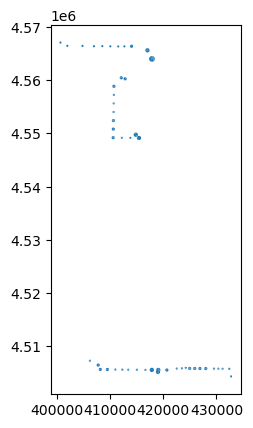

In [41]:
# Assuming gdf1, gdf2, and gdf3 are your GeoDataFrames

# Perform the intersection of the first two GeoDataFrames
gdf_buffered_stops_with_centers_taz = gpd.overlay(gdf_buffered_stops_with_centers_final, gdf_taz[['TAZID','TAZACRES','geometry']], how='intersection')

# Calculate the area in square meters
gdf_buffered_stops_with_centers_taz['sqm'] = gdf_buffered_stops_with_centers_taz.geometry.area

# Convert the area to acres
gdf_buffered_stops_with_centers_taz['acres'] = gdf_buffered_stops_with_centers_taz['sqm'] / 4046.85642

# The final_intersection GeoDataFrame now contains the intersection of all three GeoDataFrames
display(gdf_buffered_stops_with_centers_taz)
gdf_buffered_stops_with_centers_taz.plot()


In [42]:
#gdf_buffered_stops_with_centers_taz.fillna(0, inplace=True)
gdf_buffered_stops_with_centers_taz['N'] = gdf_buffered_stops_with_centers_taz['N'].astype(int)
gdf_buffered_stops_with_centers_taz['project_id'] = gdf_buffered_stops_with_centers_taz['project_id'].astype(int)
gdf_buffered_stops_with_centers_taz

,N,project_id,nearest_AreaType,TAZID,TAZACRES,geometry,sqm,acres
0,15086,2,Neighborhood Center,1472,42.036264,"POLYGON ((424043.145 4505847.017, 424036.495 4...",49740.404222,12.291122
1,15086,2,Neighborhood Center,1473,44.089344,"POLYGON ((424421.505 4505865.604, 424414.855 4...",52165.559080,12.890390
2,15086,2,Neighborhood Center,1481,68.022708,"POLYGON ((424229.000 4505722.832, 424209.282 4...",13056.790069,3.226403
3,15086,2,Neighborhood Center,1482,39.922698,"POLYGON ((424396.265 4505812.237, 424384.505 4...",11968.229688,2.957414
4,15183,1,Neighborhood Center,176,288.616036,"POLYGON ((412496.126 4566424.387, 412502.776 4...",35706.046305,8.823156
...,...,...,...,...,...,...,...,...
173,15069,2,Urban Center,1383,82.068433,"POLYGON ((418599.665 4505156.000, 418601.602 4...",163541.758588,40.412049
174,23506,2,Urban Center,1383,82.068433,"POLYGON ((418812.341 4505510.828, 418778.475 4...",10615.218005,2.623077
175,15069,2,Urban Center,1384,96.889876,"POLYGON ((419387.011 4505039.208, 419373.709 4...",208196.248028,51.446413
176,23506,2,Urban Center,1384,96.889876,"POLYGON ((419457.973 4505447.709, 419448.379 4...",34533.423293,8.533395


In [43]:
gdf_buffered_stops_with_centers_taz.to_file("intermediate/buffered-stops-with-centers-taz.geojson", format='geojson')
print('Exported')

Exported


In [44]:
gdf_buffered_stops_with_centers_dissolve = gdf_buffered_stops_with_centers_final[['N','project_id','nearest_AreaType','geometry']]
gdf_buffered_stops_with_centers_dissolve = gdf_buffered_stops_with_centers_dissolve.dissolve(by=['N', 'project_id', 'nearest_AreaType'])
gdf_buffered_stops_with_centers_dissolve.reset_index(inplace=True)

gdf_buffered_stops_with_centers_dissolve = gdf_buffered_stops_with_centers_dissolve.to_crs(epsg=4326)

gdf_buffered_stops_with_centers_dissolve.to_file('_site/data/buffered_stops.geojson')

print('Exported')

Exported


In [45]:
gdf_taz_export = gdf_taz[['TAZID','geometry']]
gdf_taz_export = gdf_taz_export.to_crs(epsg=4326)
gdf_taz_export.to_file('_site/data/taz.geojson')


In [46]:
gdf_wc_centers_export = gdf_filtered_centers
gdf_wc_centers_export = gdf_wc_centers_export.to_crs(epsg=4326)
gdf_wc_centers_export.to_file('_site/data/wc_centers.geojson')

,N,project_id,nearest_AreaType,TAZID,TAZACRES,geometry,sqm,acres
169,15069,2,Urban Center,1367,160.670849,"POLYGON ((418848.033 4505527.709, 418885.208 4...",5109.111138,1.262489
171,15069,2,Urban Center,1368,84.929219,"POLYGON ((419080.492 4505550.604, 419118.792 4...",1062.232054,0.262483
173,15069,2,Urban Center,1383,82.068433,"POLYGON ((418599.665 4505156.000, 418601.602 4...",163541.758588,40.412049
175,15069,2,Urban Center,1384,96.889876,"POLYGON ((419387.011 4505039.208, 419373.709 4...",208196.248028,51.446413
177,15069,2,Urban Center,1396,98.491949,"POLYGON ((419041.436 4504755.602, 419002.000 4...",129814.582427,32.077882


<AxesSubplot:>

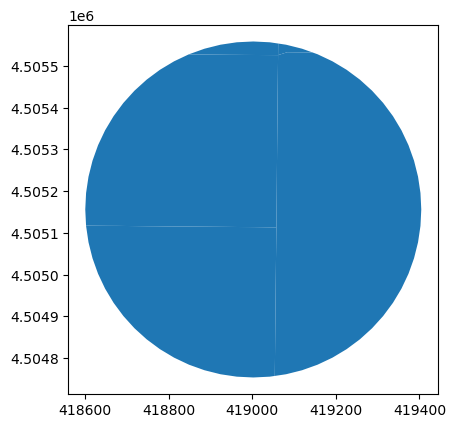

In [47]:
display(gdf_buffered_stops_with_centers_taz[gdf_buffered_stops_with_centers_taz['N']==15069])
gdf_buffered_stops_with_centers_taz[gdf_buffered_stops_with_centers_taz['N']==15069].plot()